#  Análisis Exploratorio y Feature Engineering


# Importacion de librerias

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score, classification_report
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html, Input, Output, callback
import pulp as lp
import dash_table
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


C:\Users\luis\AppData\Local\Temp\ipykernel_2024\2224790872.py:16: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table


## Cargar datos y filtrar por fecha superior a 11/11/2024

In [2]:
# Configurar estilo de gráficos
sns.set_theme(style="whitegrid")

# Cargar datos desde un archivo CSV
df = pd.read_csv('df_atencion_sucursal.txt', delimiter=';', encoding='utf-8')
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

# Filtrar datos para incluir solo desde el 11 de noviembre de 2024
df = df[df['Fecha'] >= datetime(2024, 11, 11)]

C:\Users\luis\AppData\Local\Temp\ipykernel_2024\2866739606.py:5: DtypeWarning: Columns (14,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_atencion_sucursal.txt', delimiter=';', encoding='utf-8')


## Eliminación de columnas irrelevantes para el modelo


In [3]:
columnas_a_eliminar = [
    "DNI_Cliente",             # No relevante para optimización de recursos
    "Rut_10_Cliente",          # Información redundante/privada
    "Rut_10_Ejecutivo",        # Redundante (ya existe DNI_Ejecutivo)
    "RUT_Fecha",               # Formato desconocido, posible duplicado
    "NUM"                      # Columna numérica sin contexto claro
]

# Convertir tiempo de espera a segundos y minutos
if 'Tiempo_Espera_sec' not in df.columns:
    try:
        df['Tiempo_Espera_sec'] = pd.to_timedelta(df['Tiempo_Espera']).dt.total_seconds()
    except:
        df[['Hh','Mm','Ss']] = df['Tiempo_Espera'].str.split(":", expand=True).fillna(0).astype(float)
        df['Tiempo_Espera_sec'] = df['Hh']*3600 + df['Mm']*60 + df['Ss']
        df = df.drop(columns=['Hh','Mm','Ss'])
        
df['Tiempo_Espera_min'] = df['Tiempo_Espera_sec'] / 60
# Crear columna 'Hora' desde 'Hora_Emision_Ticket'
df['Hora'] = pd.to_datetime(df['Hora_Emision_Ticket'], format='%H:%M:%S').dt.hour  # ¡Nueva línea crítica!

df_clean = df.drop(columns=columnas_a_eliminar)


## Limpieza de datos: manejar nulos y filtrar atenciones completadas


Eliminacion de columnas donde hay nulos en tiempo de espera o tiempo de atencion, tambien filtramos por las atenciones que han sido completadas, es decir las que no han sido abandonadas

In [4]:
# Eliminar filas donde Tiempo_Espera o Tiempo_Atencion son nulos (son variables clave)
df_clean = df_clean.dropna(subset=["Tiempo_Espera", "Tiempo_Atencion"])

# Filtrar solo atenciones completadas (si "Perdido" indica abandonos)
df_clean = df_clean[df_clean["Perdido"] == "no"]  # Ajustar según tus valores reales

# Reemplazar nulos en 'Nombre_Ejecutivo' por 'Sin Nombre'
df_clean['Nombre_Ejecutivo'] = df_clean['Nombre_Ejecutivo'].fillna('Sin Nombre')

## Vista de valores atipicos

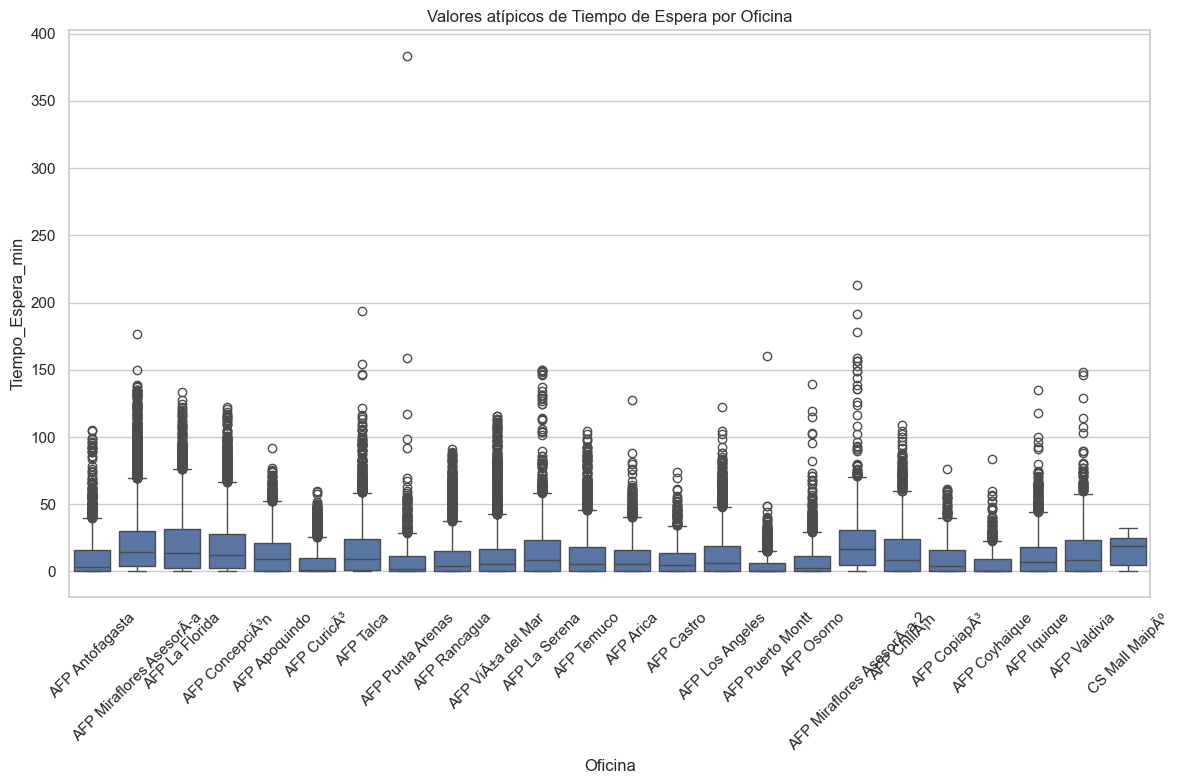

In [5]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x="Oficina", y="Tiempo_Espera_min")
plt.title("Valores atípicos de Tiempo de Espera por Oficina")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Eliminacion de valores atipicos

Estadísticas de 'Tiempo_Espera_min' tras eliminar outliers:
count    89758.000000
mean        12.050970
std         13.545547
min          0.000000
25%          0.150000
50%          7.066667
75%         19.733333
max         54.750000
Name: Tiempo_Espera_min, dtype: float64


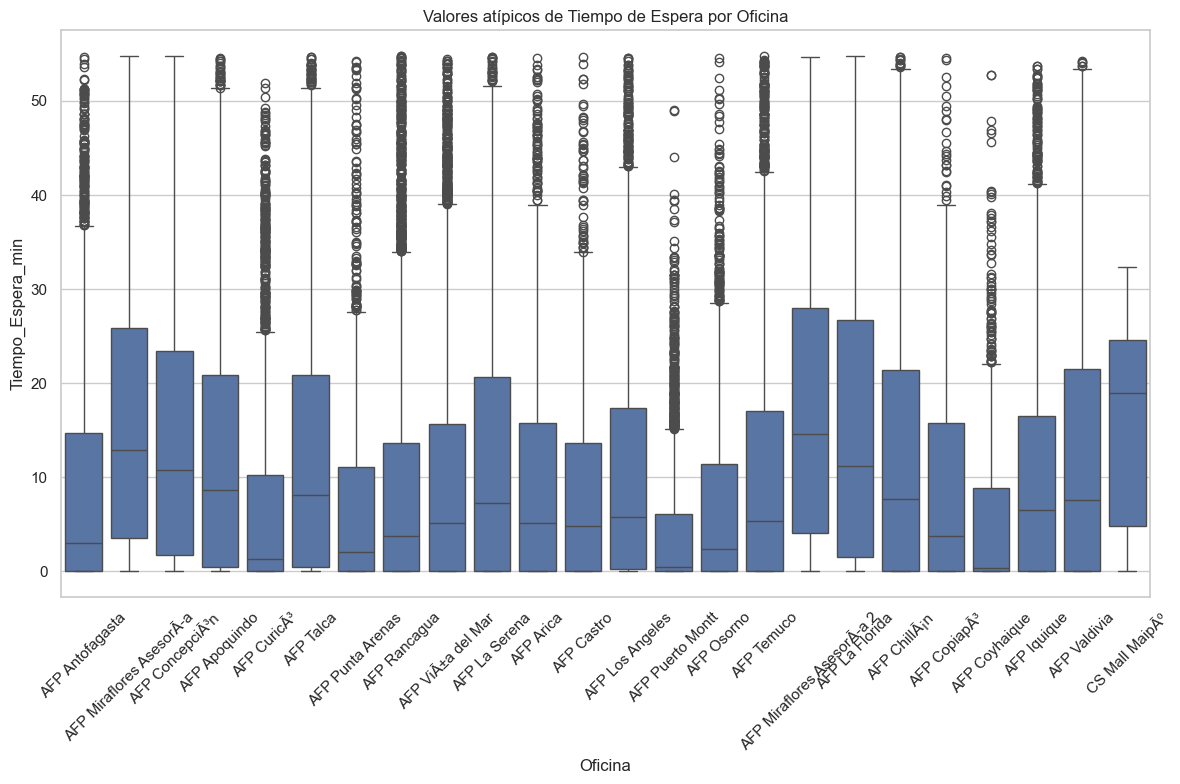

In [6]:
# Aplicar la regla de Tukey para eliminar valores atípicos en la columna "Tiempo_Espera_min"

Q1 = df_clean['Tiempo_Espera_min'].quantile(0.25)
Q3 = df_clean['Tiempo_Espera_min'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar los outliers
df_clean = df_clean[(df_clean['Tiempo_Espera_min'] >= lower_bound) & (df_clean['Tiempo_Espera_min'] <= upper_bound)]

print("Estadísticas de 'Tiempo_Espera_min' tras eliminar outliers:")
print(df_clean['Tiempo_Espera_min'].describe())

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x="Oficina", y="Tiempo_Espera_min")
plt.title("Valores atípicos de Tiempo de Espera por Oficina")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cantidad de atenciones videollamada vs presencial

Nulos en Tiempo_Espera: 0
Nulos en Tiempo_Atencion: 0


C:\Users\luis\AppData\Local\Temp\ipykernel_2024\3862841583.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=atenciones_tipo, x='Tipo', y='Cantidad', palette='viridis', ax=ax)


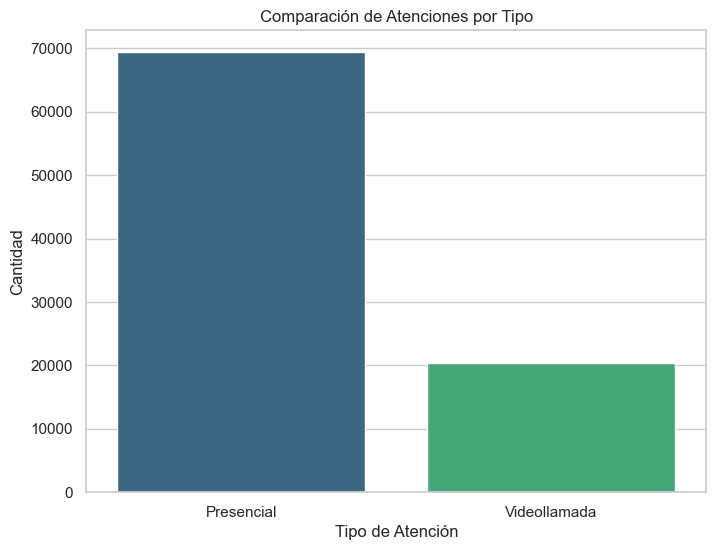

In [7]:

print("Nulos en Tiempo_Espera:", df_clean["Tiempo_Espera"].isnull().sum())
print("Nulos en Tiempo_Atencion:", df_clean["Tiempo_Atencion"].isnull().sum())

# Crear columna esVa (1 si el módulo termina en VA, 0 si no)
df_clean['esVa'] = df_clean['Modulo'].str.strip().fillna('').str.endswith('VA').astype(int)

# Crear gráfico de barras para comparar atenciones por tipo
atenciones_tipo = df_clean['esVa'].value_counts().reset_index()
atenciones_tipo.columns = ['Tipo', 'Cantidad']
atenciones_tipo['Tipo'] = atenciones_tipo['Tipo'].map({1: 'Videollamada', 0: 'Presencial'})

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=atenciones_tipo, x='Tipo', y='Cantidad', palette='viridis', ax=ax)
ax.set_title('Comparación de Atenciones por Tipo')
ax.set_xlabel('Tipo de Atención')
ax.set_ylabel('Cantidad')
plt.show()


## Productividad de ejecutivos

C:\Users\luis\AppData\Local\Temp\ipykernel_2024\2739970293.py:29: UserWarning: Glyph 26 () missing from font(s) Arial.
  plt.tight_layout()
c:\Users\luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26 () missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


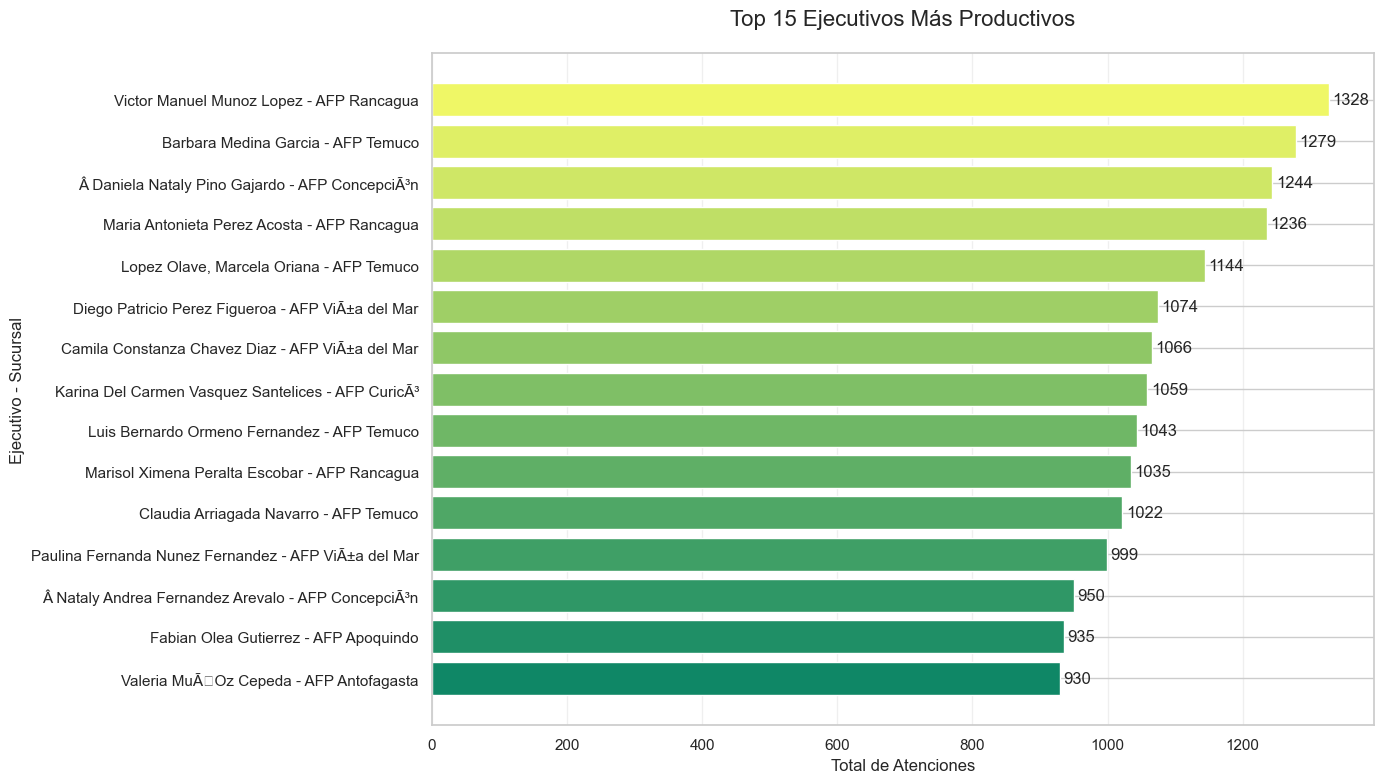

In [8]:
# Calcular atenciones por ejecutivo
atenciones_ejecutivo = df_clean.groupby(['DNI_Ejecutivo', 'Nombre_Ejecutivo', 'Oficina']).size().reset_index(name='Total_Atenciones')
atenciones_ejecutivo = atenciones_ejecutivo.sort_values('Total_Atenciones', ascending=False).reset_index(drop=True)

# Top 15 ejecutivos
top_ejecutivos = atenciones_ejecutivo.head(15)

# Gráfico de barras horizontal
plt.figure(figsize=(14, 8))
bars = plt.barh(top_ejecutivos['Nombre_Ejecutivo'] + " - " + top_ejecutivos['Oficina'], 
                top_ejecutivos['Total_Atenciones'], 
                color=sns.color_palette("summer_r", len(top_ejecutivos)))

# Personalización
plt.title('Top 15 Ejecutivos Más Productivos', fontsize=16, pad=20)
plt.xlabel('Total de Atenciones', fontsize=12)
plt.ylabel('Ejecutivo - Sucursal', fontsize=12)
plt.gca().invert_yaxis()  # Mostrar el más productivo arriba
plt.grid(axis='x', alpha=0.3)

# Añadir etiquetas de valor
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             va='center')

plt.tight_layout()
plt.show()

## Mapa de calor para determinar horas pick en sucursales

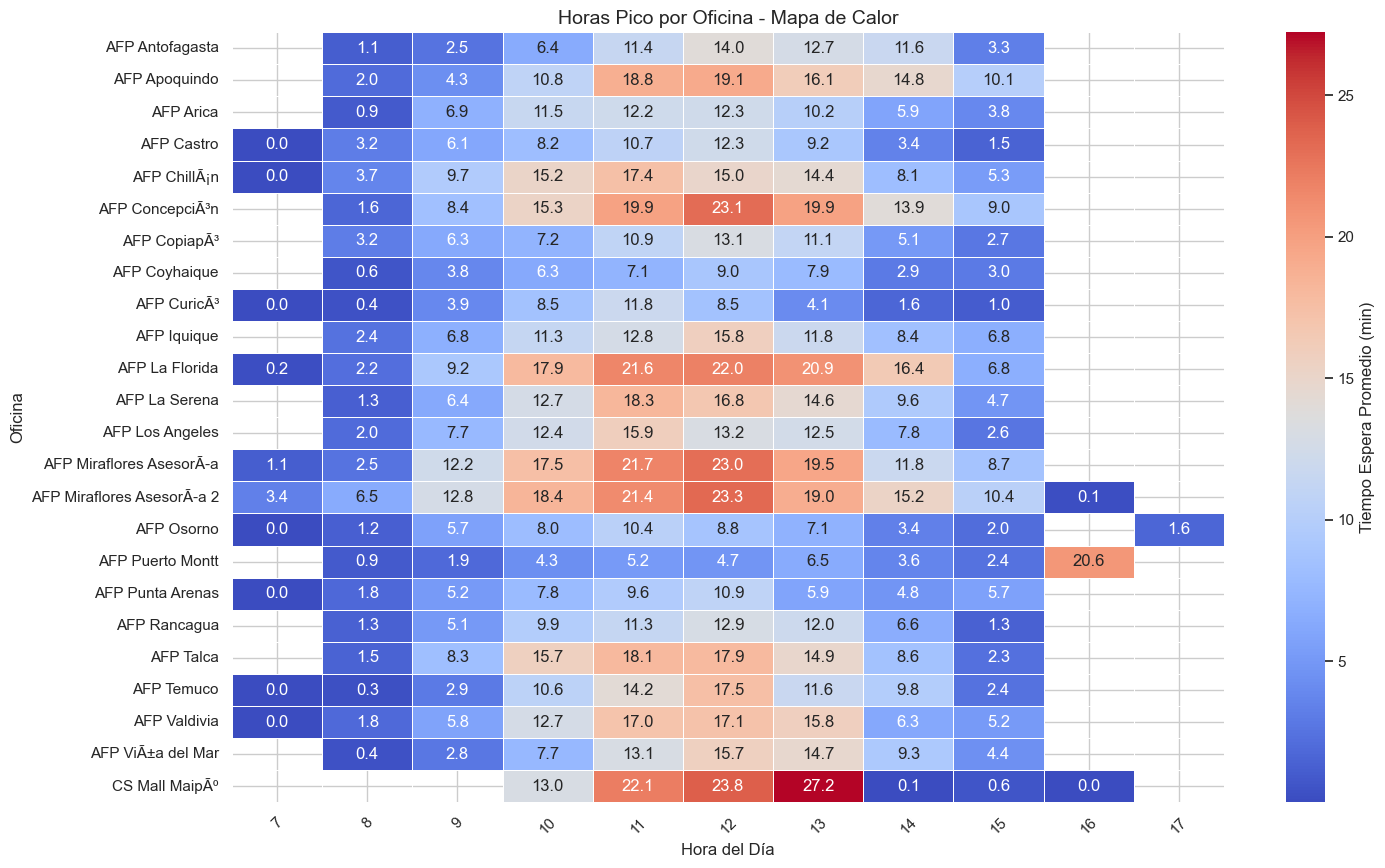

In [9]:
# Crear matriz de horas pico
heatmap_data = df_clean.pivot_table(
    index='Oficina',
    columns='Hora',
    values='Tiempo_Espera_min',
    aggfunc='mean'
)

# Configurar el gráfico
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    cbar_kws={'label': 'Tiempo Espera Promedio (min)'}
)

# Personalizar
plt.title('Horas Pico por Oficina - Mapa de Calor', fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Oficina', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

## Modelo de clasificacion bayesiano

# Identificar si los ejecutivos atienden en módulo VA al menos una vez

C:\Users\luis\AppData\Local\Temp\ipykernel_2024\662764758.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_ordered, x="Tipo", y="Total_Ejecutivos", palette="viridis")


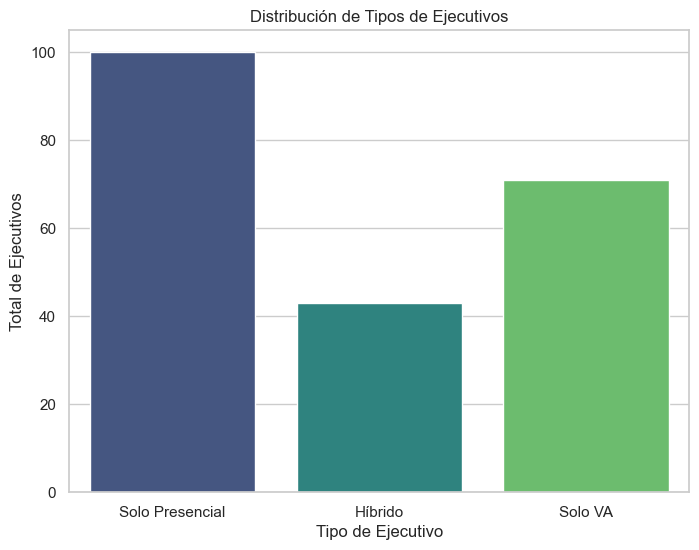

In [10]:
ejecutivos_va = df_clean.groupby('DNI_Ejecutivo', dropna=False)['esVa'].max().reset_index().rename(columns={'esVa': 'Atiende_VA'})
ejecutivos_va = ejecutivos_va.dropna(subset=['DNI_Ejecutivo'])

# Clasificación de tipo de ejecutivo
ejecutivos_tipo = df_clean.groupby('DNI_Ejecutivo', dropna=False).agg(
    Total_VA=('esVa', 'sum'), 
    Total_Atenciones=('esVa', 'size')
).reset_index()

ejecutivos_tipo['Tipo'] = 'Solo Presencial'
ejecutivos_tipo.loc[ejecutivos_tipo['Total_VA'] > 0, 'Tipo'] = 'Híbrido'
ejecutivos_tipo.loc[ejecutivos_tipo['Total_VA'] == ejecutivos_tipo['Total_Atenciones'], 'Tipo'] = 'Solo VA'

# Conteo final de tipos de ejecutivos
conteo_definitivo = ejecutivos_tipo['Tipo'].value_counts().reset_index()
conteo_definitivo.columns = ['Tipo', 'Total_Ejecutivos']
# Reordenar el DataFrame para que queden en el orden deseado:
orden = ["Solo Presencial", "Híbrido", "Solo VA"]
conteo_ordered = conteo_definitivo.set_index("Tipo").loc[orden].reset_index()

# Gráfico de barras con la distribución de ejecutivos
plt.figure(figsize=(8, 6))
sns.barplot(data=conteo_ordered, x="Tipo", y="Total_Ejecutivos", palette="viridis")
plt.title("Distribución de Tipos de Ejecutivos")
plt.xlabel("Tipo de Ejecutivo")
plt.ylabel("Total de Ejecutivos")
plt.show()

## Dashboard interactivo con Dash


In [15]:
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard de Tiempos de Espera", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id='dropdown-oficinas',
        options=[{'label': oficina, 'value': oficina} for oficina in df_clean['Oficina'].unique()],
        value=df_clean['Oficina'].iloc[0],
        style={'width': '50%', 'margin': '20px auto'}
    ),
    dcc.Graph(id='grafico-interactivo')
])

@app.callback(
    Output('grafico-interactivo', 'figure'),
    [Input('dropdown-oficinas', 'value')]
)
def actualizar_grafico(oficina_seleccionada):
    filtro = df_clean[df_clean['Oficina'] == oficina_seleccionada]
    df_hora = filtro.groupby('Hora', as_index=False).agg({
        'Tiempo_Espera_min': 'mean',
        'Perdido': 'count'
    }).rename(columns={'Perdido': 'Atenciones'})
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=df_hora['Hora'], y=df_hora['Tiempo_Espera_min'], name='Tiempo Espera (min)', line=dict(color='#1f77b4', width=2)),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Bar(x=df_hora['Hora'], y=df_hora['Atenciones'], name='Atenciones', marker=dict(color='#ff7f0e', opacity=0.6), width=0.4),
        secondary_y=True
    )
    
    fig.add_hline(y=20, line=dict(color="red", width=2, dash="dot"), annotation_text="Umbral 20 min", annotation_position="bottom right")
    
    fig.update_layout(
        title=f"Sucursal: {oficina_seleccionada}",
        template="plotly_white",
        hovermode="x unified"
    )
    
    fig.update_yaxes(title_text="<b>Tiempo de Espera (minutos)</b>", secondary_y=False, range=[0, max(df_hora['Tiempo_Espera_min'].max(), 25) + 5])
    fig.update_yaxes(title_text="<b>Volumen de Atenciones</b>", secondary_y=True)
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)

2. Modelo de KMeans para identificar sucursales problemáticas basado en métricas clave

## Modelo de KMeans para identificar sucursales problemáticas

Métricas por sucursal:
           Oficina  Tiempo_Espera_promedio  Atenciones
0  AFP Antofagasta                9.166279        3142
1    AFP Apoquindo               12.763219        5375
2        AFP Arica                9.882574        2525
3       AFP Castro                8.497501        1881
4     AFP ChillÃ¡n               12.804466        2616


c:\Users\luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\luis\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luis\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c

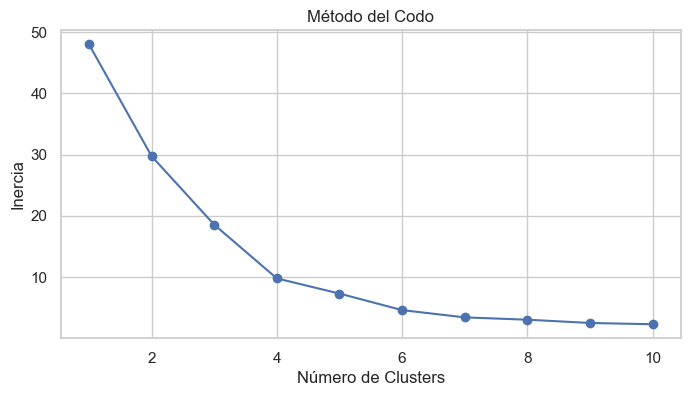


Centros de los clusters en escala original:
   Tiempo_Espera_promedio  Atenciones
0                7.758060      2492.7
1               16.884361      1103.5
2               12.720180      5836.6
3               16.309853     17142.0
4               12.170442      2716.5


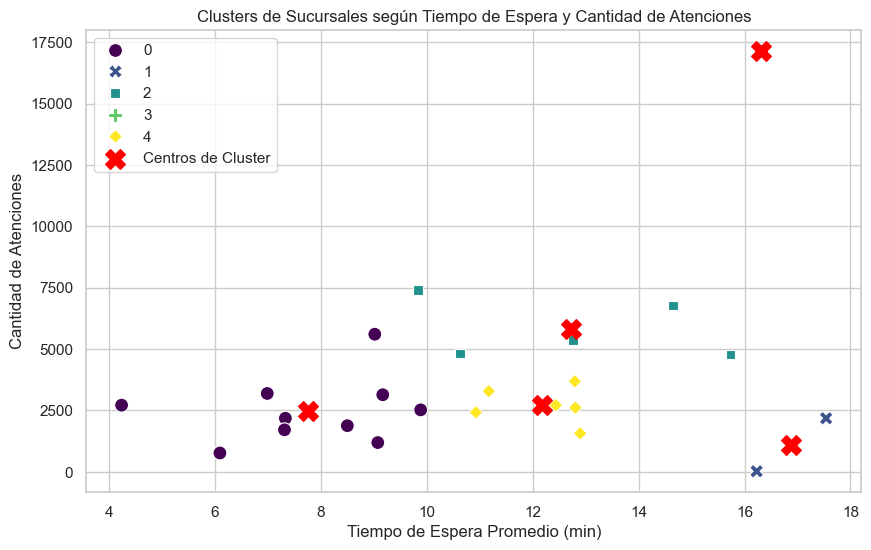

Sucursales por cluster:
Cluster 0: ['AFP Antofagasta', 'AFP Arica', 'AFP Castro', 'AFP CopiapÃ³', 'AFP Coyhaique', 'AFP CuricÃ³', 'AFP Osorno', 'AFP Puerto Montt', 'AFP Punta Arenas', 'AFP Rancagua']
Cluster 1: ['AFP Miraflores AsesorÃ\xada 2', 'CS Mall MaipÃº']
Cluster 2: ['AFP Apoquindo', 'AFP ConcepciÃ³n', 'AFP La Florida', 'AFP Temuco', 'AFP ViÃ±a del Mar']
Cluster 3: ['AFP Miraflores AsesorÃ\xada']
Cluster 4: ['AFP ChillÃ¡n', 'AFP Iquique', 'AFP La Serena', 'AFP Los Angeles', 'AFP Talca', 'AFP Valdivia']


In [12]:
# Agrupar métricas por sucursal
df_cluster = df_clean.groupby("Oficina").agg(
    Tiempo_Espera_promedio=('Tiempo_Espera_min', 'mean'),
    Atenciones=('ID_Ticket', 'count')
).reset_index()

print("Métricas por sucursal:")
print(df_cluster.head())

# Escalar las variables para análisis de clusters
scaler = StandardScaler()
features = df_cluster[["Tiempo_Espera_promedio", "Atenciones"]]
features_scaled = scaler.fit_transform(features)

# Análisis del codo para determinar número óptimo de clusters
inertias = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(features_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

# Ajuste de KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_scaled)
df_cluster["Cluster"] = kmeans.labels_

# Centros de los clusters en escala original
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=["Tiempo_Espera_promedio", "Atenciones"])
print("\nCentros de los clusters en escala original:")
print(centers_df)

# Visualización de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster,
                x="Tiempo_Espera_promedio",
                y="Atenciones",
                hue="Cluster",
                palette="viridis",
                s=100,
                style="Cluster")

plt.scatter(centers_df["Tiempo_Espera_promedio"],
            centers_df["Atenciones"],
            c="red",
            s=200,
            marker="X",
            label="Centros de Cluster")

plt.title("Clusters de Sucursales según Tiempo de Espera y Cantidad de Atenciones")
plt.xlabel("Tiempo de Espera Promedio (min)")
plt.ylabel("Cantidad de Atenciones")
plt.legend()
plt.show()

# Asignar sucursales a cada cluster
clusters = df_cluster.groupby("Cluster")["Oficina"].apply(list)
print("Sucursales por cluster:")
for cluster, oficinas in clusters.items():
    print(f"Cluster {cluster}: {oficinas}")

# Variables para su uso posterior
cluster_0 = clusters.get(0, [])
cluster_1 = clusters.get(1, [])
cluster_2 = clusters.get(2, [])
cluster_3 = clusters.get(3, [])
cluster_4 = clusters.get(4, [])

El análisis de clusters revela diferentes patrones en las sucursales de AFP según su tiempo de espera promedio y la cantidad de atenciones. El Cluster 0 agrupa sucursales con bajos tiempos de espera (~8.1 min) y una cantidad reducida de atenciones (~2164), posiblemente reflejando oficinas en ciudades con menor demanda. El Cluster 1 incluye sucursales con tiempos de espera elevados (~20.2 min) y una cantidad moderada de atenciones (~4959), indicando una posible saturación en oficinas de alta demanda. El Cluster 2 tiene tiempos de espera intermedios (~12 min) con una mayor cantidad de atenciones (~5954), lo que sugiere un balance entre demanda y capacidad de atención. El Cluster 3, con la sucursal de Miraflores Asesoría, destaca por tener el mayor número de atenciones (~18,575) y un alto tiempo de espera (~20.8 min), lo que indica una gran afluencia de clientes. Finalmente, el Cluster 4 presenta tiempos de espera de ~14.8 min y una baja cantidad de atenciones (~2433), posiblemente reflejando sucursales con flujos de atención más esporádicos o menor eficiencia operativa.

## Optimización de recursos con PuLP


Este modelo utiliza PuLP para optimizar la transferencia de ejecutivos que trabajan de forma híbrida o exclusivamente en videollamada ("Solo VA" o "Híbrido") entre distintas sucursales basándose en el tiempo de espera promedio y el volumen de atenciones por hora. Primero, identifica la oficina principal de cada ejecutivo relevante y luego calcula un "surplus" de ejecutivos en sucursales con bajos tiempos de espera y una "necesidad" en aquellas con tiempos de espera superiores a un umbral definido. Utiliza programación lineal para maximizar el número de transferencias, respetando restricciones donde no se transfieren más ejecutivos de los disponibles ni más de los necesarios en cada sucursal, proporcionando así recomendaciones específicas sobre cuántos y a qué hora mover a los ejecutivos para equilibrar la carga de trabajo y mejorar la eficiencia del servicio.

El objetivo del modelo es minimizar los tiempos de espera en las sucursales que tienen una alta demanda (aquellas donde el tiempo de espera supera un umbral específico). Se logra esto redistribuyendo los recursos humanos (ejecutivos que pueden trabajar en modalidad híbrida o exclusivamente en videollamada) desde sucursales con menor demanda (y por tanto, más ejecutivos disponibles que necesarios) hacia aquellas con mayor necesidad.

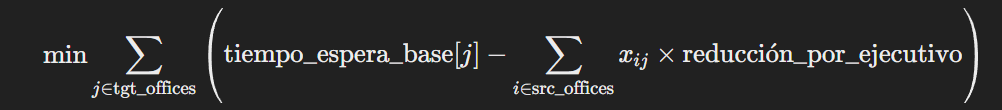

tiempo_espera_base[j]: Es el tiempo de espera promedio en la oficina j antes de transferir ejecutivos.
sumatoria Xij x reduccion_por_ejecutivo: Representa la reducción del tiempo de espera en la oficina  j si recibe ejecutivos transferidos desde otras oficinas.



observaciones: Se asume que cada ejecutivo transferido reduce el tiempo de espera en 5 minutos.
               La función objetivo busca reducir la suma total de los tiempos de espera en todas las oficinas j.


In [13]:
# Determinar la oficina principal de cada ejecutivo "Solo VA" o "Híbrido"
df_va_hibrido = df_clean[df_clean["DNI_Ejecutivo"].isin(ejecutivos_tipo[ejecutivos_tipo.Tipo.isin(['Solo VA', 'Híbrido'])]['DNI_Ejecutivo'])]

def oficina_principal(grupo):
    return grupo["Oficina"].value_counts().idxmax()

ejec_oficina = df_va_hibrido.groupby("DNI_Ejecutivo").apply(oficina_principal).reset_index()
ejec_oficina.columns = ["DNI_Ejecutivo", "Oficina_Principal"]

va_hibrido_en_oficina = ejec_oficina.groupby("Oficina_Principal")["DNI_Ejecutivo"].nunique().reset_index()
va_hibrido_en_oficina.columns = ["Oficina", "Ejecutivos_VA_Híbrido"]

def compute_recommendations(hora_seleccionada, umbral=20):
    print(f"[INFO] Recomendaciones para la hora {hora_seleccionada:02d}:00")
    
    df_hour = df_clean[df_clean["Hora"] == hora_seleccionada]
    if df_hour.empty:
        print("[warning] No hay datos para esa hora. Retorno vacío.")
        return pd.DataFrame(columns=["Desde", "Hacia", "Ejecutivos_Transferidos", "Hora_Recomendado"])
    
    df_cluster_hora = df_hour.groupby("Oficina").agg(
        Tiempo_Espera_promedio=('Tiempo_Espera_min', 'mean'),
        Atenciones=('ID_Ticket', 'count')
    ).reset_index().merge(va_hibrido_en_oficina, on="Oficina", how="left")
    
    df_cluster_hora["Ejecutivos_VA_Híbrido"] = df_cluster_hora["Ejecutivos_VA_Híbrido"].fillna(0)
    df_cluster_hora["Surplus"] = np.where((df_cluster_hora["Tiempo_Espera_promedio"] < 15) | (df_cluster_hora["Atenciones"] < 100), 
                                          df_cluster_hora["Ejecutivos_VA_Híbrido"], 0)
    df_cluster_hora["Requirement"] = np.where(df_cluster_hora["Tiempo_Espera_promedio"] > umbral, 
                                               np.ceil((df_cluster_hora["Tiempo_Espera_promedio"] - umbral) * 
                                                       (df_cluster_hora["Atenciones"] / 5.0) * 1.2).astype(int), 0)
    
    print("[DEBUG] Datos agregados por sucursal:")
    print(df_cluster_hora)

    # Añadir una alerta para sucursales a punto de colapsar
    alertas = df_cluster_hora[df_cluster_hora["Tiempo_Espera_promedio"] > 30]  # ejemplo de condición
    if not alertas.empty:
        print("[ALERTA] Las siguientes sucursales están en riesgo de colapso:")
        for _, row in alertas.iterrows():
            print(f"- {row['Oficina']}: {row['Tiempo_Espera_promedio']:.1f} min, se recomienda mover {row['Requirement']} ejecutivos.")
    
    src = df_cluster_hora[df_cluster_hora["Surplus"] > 0].copy()
    tgt = df_cluster_hora[df_cluster_hora["Requirement"] > 0].copy()
    
    print("[DEBUG] Oficinas con Surplus:")
    print(src)
    print("[DEBUG] Oficinas con Requirement:")
    print(tgt)

    if src.empty or tgt.empty:
        print("[INFO] No hay oficinas con Surplus o con Requirement. Retorno vacío.")
        return pd.DataFrame(columns=["Desde", "Hacia", "Ejecutivos_Transferidos", "Hora_Recomendado"])

    src_offices = src["Oficina"].tolist()
    tgt_offices = tgt["Oficina"].tolist()
    
    # Construir el modelo de optimización
    prob = lp.LpProblem("Minimizar_Tiempo_Espera", lp.LpMinimize)
    
    # Variables de decisión
    x = lp.LpVariable.dicts(
        "x",
        [(i, j) for i in src_offices for j in tgt_offices],
        lowBound=0,
        cat=lp.LpInteger
    )
    
    # Estimación de reducción de tiempo de espera por ejecutivo transferido (esto es una suposición simplificada)
    tiempo_espera_base = dict(zip(df_cluster_hora["Oficina"], df_cluster_hora["Tiempo_Espera_promedio"]))
    reduccion_por_ejecutivo = 5  # Ejemplo: cada ejecutivo adicional reduce el tiempo de espera en 5 minutos
    
    # Función objetivo: Minimizar el tiempo de espera ajustado
    prob += lp.lpSum([tiempo_espera_base[j] - reduccion_por_ejecutivo * lp.lpSum(x[(i, j)] for i in src_offices) 
                      for j in tgt_offices if j in tiempo_espera_base]), "Minimizar_Tiempo_Espera"
    
    # Restricciones
    surplus_dict = dict(zip(src["Oficina"], src["Surplus"]))
    for i in src_offices:
        prob += lp.lpSum(x[(i, j)] for j in tgt_offices) <= surplus_dict[i], f"Surplus_{i}"

    req_dict = dict(zip(tgt["Oficina"], tgt["Requirement"]))
    for j in tgt_offices:
        prob += lp.lpSum(x[(i, j)] for i in src_offices) <= req_dict[j], f"Requirement_{j}"
    
    print("[DEBUG] Modelo de optimización:")
    print(prob)
    
    # Resolver el modelo
    prob.solve(lp.PULP_CBC_CMD(msg=0))
    
    print("[DEBUG] Estado de la solución:", lp.LpStatus[prob.status])
    print("[DEBUG] Valor objetivo (tiempo de espera ajustado):", lp.value(prob.objective))
    for v in prob.variables():
        if v.varValue and v.varValue > 0:
            print(f"[DEBUG] {v.name} = {v.varValue}")
    
    # Recopilar resultados en un DataFrame
    rows = []
    for i in src_offices:
        for j in tgt_offices:
            val = lp.value(x[(i, j)])
            if val and val > 0:
                rows.append({
                    "Desde": i,
                    "Hacia": j,
                    "Ejecutivos_Transferidos": int(val),
                    "Hora_Recomendado": f"{hora_seleccionada:02d}:00"
                })
    df_result = pd.DataFrame(rows)
    
    print("[INFO] Movimientos recomendados:")
    print(df_result)
    print("======================================================\n")
    
    return df_result

C:\Users\luis\AppData\Local\Temp\ipykernel_2024\138746510.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## Dashboard de recomendaciones de transferencia de ejecutivos


In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard: Transferencia de Ejecutivos 'Solo VA' y 'Híbrido'"),
    html.P("Reasigna ejecutivos a sucursales con tiempo de espera > umbral para satisfacer la demanda."),
    
    html.Div([
        html.Label("Selecciona la hora de transferencia (0-23):"),
        dcc.Dropdown(
            id="dropdown-hora",
            options=[{"label": f"{h:02d}:00", "value": h} for h in range(24)],
            value=datetime.now().hour,
            style={"width": "30%"}
        )
    ], style={"margin": "20px"}),
    
    html.Div([
        html.Label("Ajustar umbral de tiempo de espera (minutos):"),
        dcc.Slider(
            id='threshold-slider',
            min=10,
            max=30,
            step=1,
            value=20,
            marks={i: str(i) for i in range(10, 31, 5)}
        ),
    ], style={'margin': '20px'}),
    
    dcc.Interval(id='interval-component', interval=60000, n_intervals=0),
    
    dash_table.DataTable(
        id='recommendation-table',
        columns=[
            {"name": "Desde", "id": "Desde"},
            {"name": "Hacia", "id": "Hacia"},
            {"name": "Ejecutivos a Transferir", "id": "Ejecutivos_Transferidos"},
            {"name": "Hora Recomendado", "id": "Hora_Recomendado"}
        ],
        data=[],
        style_table={'overflowX': 'auto', 'width': '80%'},
        style_cell={'textAlign': 'center'},
        page_size=10
    ),
    
    html.Div(id='last-update', style={'marginTop': 20, 'fontStyle': 'italic'})
])

@callback(
    Output('recommendation-table', 'data'),
    Output('last-update', 'children'),
    Input('interval-component', 'n_intervals'),
    Input('dropdown-hora', 'value'),
    Input('threshold-slider', 'value')
)
def update_dashboard(n_intervals, hora, umbral):
    rec_df = compute_recommendations(hora, umbral)
    update_time = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
    return rec_df.to_dict('records'), f"Última actualización: {update_time}"

if __name__ == '__main__':
    app.run_server(debug=True, port=8050, use_reloader=False)

[INFO] Recomendaciones para la hora 15:00
[DEBUG] Datos agregados por sucursal:
                       Oficina  Tiempo_Espera_promedio  Atenciones  \
0              AFP Antofagasta                3.274886          73   
1                AFP Apoquindo               10.112010         136   
2                    AFP Arica                3.849091          55   
3                   AFP Castro                1.470567          47   
4                 AFP ChillÃ¡n                5.324648          71   
5              AFP ConcepciÃ³n                8.956686         172   
6                 AFP CopiapÃ³                2.734259          18   
7                AFP Coyhaique                2.980303          22   
8                  AFP CuricÃ³                1.012121          33   
9                  AFP Iquique                6.761950          53   
10              AFP La Florida                6.772745          85   
11               AFP La Serena                4.708201          63   
12        